# Shapley Tests

## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple, List

# Standard Libraries
from enum import Enum, auto
from pathlib import Path
from operator import lt, gt
from math import sqrt, pi, sin, cos, tan, radians, acos
from math import isnan
from statistics import mean
from collections import Counter, defaultdict
from dataclasses import dataclass, field, asdict
from itertools import zip_longest

from pprint import pprint

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
#import PySimpleGUI as sg
import networkx as nx
import pydicom
import shapely
from shapely.plotting import plot_polygon, plot_points

# Local functions and classes
from types_and_classes import *
from utilities import *
from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2


In [3]:
%matplotlib inline

# Test structures
- **CONTAINS**
  - Concentric spheres
  - Concentric embedded Rings
  - Concentric spheres with centres offset
  - Parallel Cylinders for 1st structure containing cylinder in 1 of them
- **SHELTERS**
  - Half box sheltering box
  - Vertical open box sheltering box
- **SURROUNDS**
  - Concentric hollow spheres
  - Concentric Rings
  - Offset hollow boxes
- **OVERLAPS**
  - Overlapping Boxes Lateral
  - Overlapping Boxes Vertical
- 

### Distance Tests

#### Disjoint

<link rel="stylesheet" href="relations.css">
<table width="300px">
<tr class="l"><th>Disjoint</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The Convex Hull of 
<span class="a">a</span> has no points in common with <span class="b">b</span>.</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/disjoint.png" alt="Disjoint" style="width: 200px">
</td></tr></table>

 #### Vertical Concentric Cylinders
 
 ![Concentric Cylinders](./Images/FreeCAD%20Images/ConcentricCylinders.png)

In [ ]:
slice_spacing = 0.5
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

cylinder6 = make_vertical_cylinder(roi_num=1, radius=6, length=10,
                                   spacing=slice_spacing)
cylinder4 = make_vertical_cylinder(roi_num=2, radius=4, length=10,
                                   spacing=slice_spacing)
# combine the contours
slice_data = pd.concat([body, cylinder6, cylinder4])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)


In [ ]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
print(relation)
print('Expected Margins: 2 cm in all directions.')
m = MarginMetric(structures, slice_table=slice_table, relation=relation)
print(m.format_metric())


Relationship: Partition
Expected Margins: 2 cm in all directions.
        2.0   0.0  
        ANT  SUP       
         | /           
         |/            
2.0 RT--- ---LT 2.0  
        /|             
       / |             
   INF  POST           
  0.0   2.0       

Min: 0.0   Max: 2.0


In [ ]:
def disjoint_example():
    circle4_left = shapely.Polygon(circle_points(4, offset_x=-4.5))
    circle4_right = shapely.Polygon(circle_points(4, offset_x=4.5))

    a = StructureSlice([circle4_left])
    b = StructureSlice([circle4_right])
    print('Expected Distance: 1.0')
    return a, b


In [ ]:
a, b = disjoint_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
distances(a, b, relation)

## Margins
- $Margin_\perp = bounds(a) − bounds(b)$

- $Margin_{min} = distance(a,b)$

- $Margin_{max} = distance_{housdorff}(a,b)$

**Z direction metrics**
- Orthogonal:
  - The distance between the last slice containing $a$ and the last slice 
      of $b$ where the last contour of $a$ overlaps with the contour of $b$
- Max:
  - The larger of $\Delta Z$ or $d_{2D}$
- Min:
  - The Smaller of $d_{min}^{2D}$ and $\Delta Z$,<br>
      

**Used By:**
- Contains
- Surrounds
- Shelters (Does not use $Margin_{max}$)


**RuntimeWarning** is a know bug in current version of shapely 

```
d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance

  return lib.hausdorff_distance(a, b, **kwargs)

d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance

  return lib.distance(a, b, **kwargs)
```

- **TODO** Use warnings module to suppress this message

### Make test structures


**Z direction metrics**
  - % Volume and % Surface Area:
    - No additional calculations.
  - Distance: 
    - The larger of $\Delta Z$ or $d_{2D}$


 #### Vertical Concentric Cylinders
 
 ![Concentric Cylinders](./Images/FreeCAD%20Images/ConcentricCylinders.png)

In [4]:
slice_spacing = 0.5
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

cylinder6 = make_vertical_cylinder(roi_num=1, radius=6, length=10,
                                   spacing=slice_spacing)
cylinder4 = make_vertical_cylinder(roi_num=2, radius=4, length=10,
                                   spacing=slice_spacing)
# combine the contours
slice_data = pd.concat([body, cylinder6, cylinder4])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)


In [6]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
print(relation)
print('Expected Margins: 2 cm in all directions.')
m = MarginMetric(structures, slice_table=slice_table, relation=relation)
print(m.format_metric())


Relationship: Partition
Expected Margins: 2 cm in all directions.
        2.0   0.0  
        ANT  SUP       
         | /           
         |/            
2.0 RT--- ---LT 2.0  
        /|             
       / |             
   INF  POST           
  0.0   2.0       

Min: 0.0   Max: 2.0


#### Stacked Spheres

![Stacked Spheres 1](./Images/FreeCAD%20Images/StackedSpheres1.png)

In [43]:
slice_spacing = 0.5
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

# Three spheres stacked vertically
sphere3_sup = make_sphere(roi_num=1, radius=3, offset_z=4,
                          spacing=slice_spacing)
sphere3_inf = make_sphere(roi_num=1, radius=3, offset_z=-4,
                          spacing=slice_spacing)
sphere3_inf2 = make_sphere(roi_num=1, radius=3, offset_z=-12,
                           spacing=slice_spacing)

# Single 2 cm sphere within centre sphere of other structure
sphere2_inf = make_sphere(roi_num=2, radius=2, offset_z=-4,
                          spacing=slice_spacing)

# combine the contours
slice_data = pd.concat([sphere3_sup, sphere3_inf, sphere3_inf2,
                                sphere2_inf, body])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)

# Note: Max distance is 2.2.  Is this appropriate?

In [44]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
get_margins(structures, slice_table, relation)

d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


x_neg    1.000
y_neg    1.000
x_pos    1.000
y_pos    1.000
max      2.235
min      0.981
z_neg    1.000
z_pos    1.000
dtype: float64

#### Stacked Spheres with Vertical Offset

![Stacked Spheres Offset](./Images/FreeCAD%20Images/StackedSpheresOffset.png)

In [45]:
slice_spacing = 0.5
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

# Three spheres stacked vertically
sphere3_sup = make_sphere(roi_num=1, radius=3, offset_z=4,
                          spacing=slice_spacing)
sphere3_inf = make_sphere(roi_num=1, radius=3, offset_z=-4,
                          spacing=slice_spacing)
sphere3_inf2 = make_sphere(roi_num=1, radius=3, offset_z=-12,
                           spacing=slice_spacing)

# Single 2 cm sphere within the centre sphere of other structure, but offset
# vertically by 0.5 cm from the centre of that sphere
sphere2_inf = make_sphere(roi_num=2, radius=2, offset_z=-3.5,
                          spacing=slice_spacing)

# combine the contours
slice_data = pd.concat([sphere3_sup, sphere3_inf, sphere3_inf2,
                                sphere2_inf, body])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)

In [46]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
get_margins(structures, slice_table, relation)

d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


x_neg    0.866
y_neg    0.866
x_pos    0.866
y_pos    0.866
max      2.597
min      0.500
z_neg    1.500
z_pos    0.500
dtype: float64

In [47]:
slice_spacing = 0.5
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

# Three spheres stacked vertically
sphere3_sup = make_sphere(roi_num=1, radius=3, offset_z=4,
                          spacing=slice_spacing)
sphere3_inf = make_sphere(roi_num=1, radius=3, offset_z=-4,
                          spacing=slice_spacing)
sphere3_inf2 = make_sphere(roi_num=1, radius=3, offset_z=-12,
                           spacing=slice_spacing)

# Single 2 cm sphere within the centre sphere of other structure, but offset
# vertically by 0.5 cm from the centre of that sphere
sphere2_inf = make_sphere(roi_num=2, radius=2, offset_z=-3.5, offset_x=0.5,
                          spacing=slice_spacing)

# combine the contours
slice_data = pd.concat([sphere3_sup, sphere3_inf, sphere3_inf2,
                                sphere2_inf, body])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)

In [48]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
get_margins(structures, slice_table, relation)

d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


x_neg    1.366
y_neg    0.766
x_pos    0.366
y_pos    0.766
max      3.097
min      0.359
z_neg    1.000
z_pos    0.000
dtype: float64

In [49]:
slice_spacing = 0.2
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

# Three spheres stacked vertically
sphere3_sup = make_sphere(roi_num=1, radius=3, offset_z=4,
                          spacing=slice_spacing)
sphere3_inf = make_sphere(roi_num=1, radius=3, offset_z=-4,
                          spacing=slice_spacing)
sphere3_inf2 = make_sphere(roi_num=1, radius=3, offset_z=-12,
                           spacing=slice_spacing)

# Single 2 cm sphere within the centre sphere of other structure, but offset
# vertically by 0.5 cm from the centre of that sphere
sphere2_inf = make_sphere(roi_num=2, radius=2, offset_z=-3.6, offset_x=0.5,
                          spacing=slice_spacing)

# combine the contours
slice_data = pd.concat([sphere3_sup, sphere3_inf, sphere3_inf2,
                                sphere2_inf, body])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)

In [50]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
get_margins(structures, slice_table, relation)

d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


x_neg    1.416
y_neg    0.817
x_pos    0.416
y_pos    0.817
max      3.037
min      0.408
z_neg    1.200
z_pos    0.400
dtype: float64

In [51]:
slice_spacing = 0.1
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

# Three spheres stacked vertically
sphere3_sup = make_sphere(roi_num=1, radius=3, offset_z=4,
                          spacing=slice_spacing)
sphere3_inf = make_sphere(roi_num=1, radius=3, offset_z=-4,
                          spacing=slice_spacing)
sphere3_inf2 = make_sphere(roi_num=1, radius=3, offset_z=-12,
                           spacing=slice_spacing)

# Single 2 cm sphere within the centre sphere of other structure, but offset
# vertically by 0.5 cm from the centre of that sphere
sphere2_inf = make_sphere(roi_num=2, radius=2, offset_z=-3.5, offset_x=0.5,
                          spacing=slice_spacing)

# combine the contours
slice_data = pd.concat([sphere3_sup, sphere3_inf, sphere3_inf2,
                                sphere2_inf, body])


In [52]:

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)

In [53]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
print('Expected Margins: 3 cm in all directions.')
get_margins(structures, slice_table, relation)

Expected Margins: 3 cm in all directions.


d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
d:\.conda\envs\StructureRelations\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


x_neg    1.366
y_neg    0.766
x_pos    0.366
y_pos    0.766
max      3.097
min      0.359
z_neg    1.400
z_pos    0.400
dtype: float64

# Done to Here

#### Horizontal Cylinders

![Horizontal Cylinders](./Images/FreeCAD%20Images/HorizontalCylinders.png)

In [54]:
slice_spacing = 0.1
# Body structure defines slices in use
body = make_box(roi_num=0, width=6, length=6, height=8, offset_z=-4,
                spacing=slice_spacing)

cylinder2h = make_horizontal_cylinder(radius=2, length=5, spacing=slice_spacing,
                                      roi_num=1)
cylinder1h = make_horizontal_cylinder(radius=1, length=5, spacing=slice_spacing,
                                      roi_num=2)
# combine the contours
slice_data = pd.concat([body, cylinder1h, cylinder2h])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)


In [55]:
structures = tuple([1, 2])
relation = Relationship(structures, slice_table).relationship_type
print(relation)
print('Expected Margins: 2.0 cm in all directions.', )
get_margins(structures, slice_table, relation)


Relationship: Partition
Expected Margins: 2.0 cm in all directions.


x_neg    0.5
y_neg    0.0
x_pos    0.5
y_pos    0.0
max      1.0
min      0.0
z_neg    1.0
z_pos    1.0
dtype: float64

In [57]:
relationship_1_2 = Relationship((1, 2), slice_table)
print(relationship_1_2.relationship_type)

Relationship: Partition


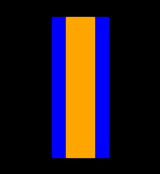

In [58]:
slice = slice_table.loc[0,:]
plot_ab(slice[1].contour, slice[2].contour)

#### Embedded Spheres with Island

![Embeded Spheres](./Images/FreeCAD%20Images/EmbeddedSpheres.png)

In [ ]:
slice_spacing = 0.5
# Body structure defines slices in use
body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                              spacing=slice_spacing)

# Hollow Sphere with island
sphere2 = make_sphere(roi_num=4, radius=2, spacing=0.5)
sphere6 = make_sphere(roi_num=5, radius=6, spacing=0.5)
sphere4 = make_sphere(roi_num=5, radius=4, spacing=0.5)
sphere3 = make_sphere(roi_num=5, radius=3, spacing=0.5)

# combine the contours
slice_data = pd.concat([body, sphere2, sphere6, sphere4, sphere3])

# convert contour slice data into a table of slices and structures
slice_table = make_slice_table(slice_data, ignore_errors=True)


In [ ]:
structures = tuple([5, 4])
relation = Relationship(structures, slice_table).relationship_type
print(relation)
print('Expected Margins: 1.0 cm in all directions.', )
get_margins(structures, slice_table, relation)


In [ ]:
# 6 cm x 6 cm box
box6 = shapely.Polygon(box_points(6))
slices = make_slice_list(5)
slices_1 = make_contour_slices(box6, roi_num=1, number_slices=5)

# 4 cm x 4 cm box
box4 = shapely.Polygon(box_points(4))
slices = make_slice_list(5)
#slices = make_slice_list(5, start=0.2, spacing=0.2)
slices_2 = make_contour_slices(2, slices, [box4])

# 6 cm x 6 cm box offset right by 3 cm
offset_box6 = shapely.Polygon(box_points(6, offset_x=3))
slices = make_slice_list(5)
#slices = make_slice_list(5, start=0.2, spacing=0.2)
slices_3 = make_contour_slices(3, slices, [offset_box6])

# 6 cm x 6 cm box with 4cm x 4 cm hole
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
slices = make_slice_list(5, start=0.2)
slices_4 = make_contour_slices(4, slices, [box6, box4])

# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
slices = make_slice_list(5)
#slices = make_slice_list(5, start=0.2, spacing=0.2)
slices_5 = make_contour_slices(5, slices, [box2a, box2b])

# 2 cm x 2 cm box offset inf by 0.3 cm
slices = make_slice_list(5, start=-0.3)
slices_6 = make_contour_slices(6, slices, [offset_box6])


In [ ]:
spacing: float = 0.1
radius: float = 1
number_slices = ceil(radius * 2 / spacing) + 1
start_slice = - radius
z_coord = make_slice_list(number_slices, start_slice, spacing)
r_coord = circle_x_points(radius, z_coord)


In [ ]:
slice_points = []
for slice, xy_points in sphere_points(1).items():
    xy = np.array(xy_points)
    z = np.ones((np.size(xy ,0), 1)) * slice
    xyz = np.concatenate([xy, z], axis=1)
    slice_points.append(xyz)
sphere = np.concatenate(slice_points)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(sphere[:,0], sphere[:,1], sphere[:,2], marker='.', linestyle='none', color='red')
ax.set_aspect('equal')
plt.show()

In [ ]:
a = make_sphere(radius=2, spacing=0.1, roi_num=0)
b = make_sphere(radius=1, spacing=0.1, roi_num=1)
slice_data = pd.concat([a, b])
slice_table = make_slice_table(slice_data)
plot_roi(slice_table, [0,1])

In [ ]:
a = make_vertical_cylinder(radius=2, length= 5, spacing=0.1, roi_num=0)
b = make_vertical_cylinder(radius=1, length= 5, spacing=0.1, roi_num=1)
slice_data = pd.concat([a, b])
slice_table = make_slice_table(slice_data)
plot_roi(slice_table, [0,1])

In [ ]:
a = make_horizontal_cylinder(radius=2, length=5, spacing=0.1, roi_num=0)
b = make_horizontal_cylinder(radius=1, length=5, spacing=0.1, roi_num=1)
slice_data = pd.concat([a, b])
slice_table = make_slice_table(slice_data)
plot_roi(slice_table, [0,1])

### Margin Tests

#### Contains

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Contains</th><th>Transitive</th></tr>
<td class="d" colspan="2">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/contains simple.png" alt="Contains">
<img src="Images/Relationships/contains with hole.png" alt="Contains With Hole">
</td></tr>
</table></td></tr></table>

In [ ]:
def contains_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    print('Expected Margins: 1 cm in all directions.', )
    return a, b

def contains_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle3])
    b = StructureSlice([circle2])
    print('Expected Margins: 0.5 cm in all directions.', )
    return a, b

def contains_example3():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle2])
    b = StructureSlice([circle5, circle3])
    print('Expected Margins: 0.5 cm in all directions.', )
    return a, b

def contains_example4():
    circle6 = shapely.Polygon(circle_points(3))
    circle3_offset_x = shapely.Polygon(circle_points(1.5, offset_x=1.2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle3_offset_x])
    print('Expected Margins:\n\t-X: 2.7\t+X: 0.3\ty: < 1.5', )
    return a, b

def contains_example5():
    circle6_offset = shapely.Polygon(circle_points(3, offset_y=-1))
    circle3_offset = shapely.Polygon(circle_points(1.5,
                                                     offset_x=0.5,
                                                     offset_y=-2))
    a = StructureSlice([circle6_offset])
    b = StructureSlice([circle3_offset])
    print('Expected Margins:\n\t-X: 2.0<1.0\t+X: <1.0\t-y: < 2.5\t+y: < 0.5', )
    return a, b

def contains_example6():
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle4_right = shapely.Polygon(circle_points(2, offset_x=3))
    circle3_left = shapely.Polygon(circle_points(1.5, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle5_up = shapely.Polygon(circle_points(2.5, offset_y=4))
    circle2_up = shapely.Polygon(circle_points(1, offset_y=3))
    circle3_down = shapely.Polygon(circle_points(1.5, offset_y=-2.5))
    circle1_down = shapely.Polygon(circle_points(0.5, offset_y=-2))
    a = StructureSlice([circle4_left, circle4_right, circle5_up, circle3_down])
    b = StructureSlice([circle3_left, circle3_right, circle2_up, circle1_down])
    print('Expected Margins:\n','\n'.join([
        '\t-X:  0.5\t+X:  0.5  \t-y: 0.5  \t+y: 0.5\t',
        '\t-X:  0.5\t+X:  0.5  \t-y: 0.5  \t+y: 0.5\t',
        '\t-X: <1.5\t+X: <1.5  \t-y: 0.5  \t+y: 2.5\t',
        '\t-X: <1.0\t+X: <1.0  \t-y: 1.5  \t+y: 0.5\t'
        ]))
    return a, b

In [ ]:
a, b = contains_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)


In [ ]:
a, b = contains_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

In [ ]:
a, b = contains_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

In [ ]:
a, b = contains_example4()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

In [ ]:
a, b = contains_example5()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

In [ ]:
a, b = contains_example6()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

#### Surrounds

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Surrounds</th><th>Transitive</t></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> have no interior points in common, and with holes filled <span class="b">b</span> lies in the interior of <span class="a">a</span>.
</td></tr><tr><td colspan="2">
<img src="Images/Relationships/surrounds simple.png" alt="surrounds simple">
<img src="Images/Relationships/surrounds with ring.png" alt="surrounds ring">
</td></tr>
</table></td></tr></table>


In [ ]:
def surrounds_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    print('Expected Margins: 1 cm in all directions.', )
    return a, b

def surrounds_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle5, circle2])
    b = StructureSlice([circle4, circle3])
    print('Expected Margins: 0.5 cm in all directions.', )
    return a, b

def surrounds_example3():
    box10x5 = shapely.Polygon(box_points(10,5))
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle2_left = shapely.Polygon(circle_points(1, offset_x=-3, offset_y=0.5))
    circle2_right = shapely.Polygon(circle_points(1, offset_x=3))
    a = StructureSlice([box10x5, circle4_left, circle3_right, circle2_right])
    b = StructureSlice([circle2_left])
    print('Expected Margins:\n\tX: < 1.0\t-Y: 1.5  \t+y: < 0.5', )
    return a, b

In [ ]:
a, b = surrounds_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)


In [ ]:
a, b = surrounds_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

In [ ]:
a, b = surrounds_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

#### Shelters

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Shelters</th><th>Transitive</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have no points in common, 
but the Convex Hull of <span class="a">a</span> contains <span class="b">b</span>.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/shelters.png" alt="Shelters">
</td></tr>
</table></td></tr></table>

In [ ]:
def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    x_min_margin = 5.0/2 - 2.0/2 + 1.0   # Margin to contour
    cove_edge = cove.bounds[2]
    x_max_margin = cove_edge - 2.0/2 - 1.0   # Margin to Hull
    y_edge = sqrt(2.5*2.5 - 1)
    y_margin = y_edge - 2.0/2
    print(''.join([
        f'Expected Margins:\n\t',
        f'-X: {x_min_margin:3.2f}  ',
        f'+X:{x_max_margin:3.2f}  ',
        f'Y: {y_margin:3.2f}'
        ]))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])

    return a, b


In [ ]:
a, b = shelters_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

## Distance
- $Distance = distance(a,b)$

**Z direction metrics**

- The larger of $\Delta Z$ or $d_{2D}$

**Used By:**
- Disjoint


## Ratio of Volumes

Ratio of the overlapping volume to the average or larger volume.
$R_V =\frac{V( a \cap b )}{\overline{V_{a,b}}}$

Since the structures are compared slice by slice, the Volume function can be written as:<br>
$V(x) = t \times \operatorname{area} ( x )$,<br>
where $t$ is the slice thickness. 

When calculating the ratio, slice thickness is a constant, so the Volume ratio is equal to the ratio sums of the areas over all slices:
  
$R_V =\frac{\sum_s \operatorname{area}( a \cap b )}{\sum_s \overline{\operatorname{area}_{a,b}}}$

*Used By:*

- **Overlaps**
> - Ratio of the volume of overlap to the average volume of $a$ and $b$:
> - $R_v =\frac{\sum_s \left[ 2 \times \operatorname{area}( a \cap b ) \right] }{\sum_s \left[ \operatorname{area}( a ) + \operatorname{area}( b ) \right] }$


- **Partition**
> - Ratio of the volume of the overlap to the volume of the larger structure ($a$):
> - $R_V =\frac{\sum_s \operatorname{area}( a \cap b )}{\sum_s \operatorname{area}( a )}$


<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Overlaps</th><th>Symmetric</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have some but not all points in common.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/overlaps simple.png" alt="Overlaps">
<img src="Images/Relationships/overlaps ring.png" alt="Overlaps With Ring">
<img src="Images/Relationships/overlaps surounded.png" alt="Overlaps Surrounded">
<img src="Images/Relationships/overlaps ring surrounds simple.png" alt="Ring Overlaps Simple">
<img src="Images/Relationships/archipelago contains simple.png" alt="Ring Overlaps Simple">
</td></tr></table>

In [ ]:
def overlaps_box_example():
    box4 = shapely.Polygon(box_points(4))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))

    area_a = 4 * 4
    area_b = 4 * 4
    average_area = (area_a + area_b) / 2
    overlapping_area = 4 * 2
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box4])
    b = StructureSlice([box4_offset])
    return a, b

def overlaps_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    box6_offset = shapely.Polygon(box_points(6, offset_x=3))

    area_a = pi * 3**2
    area_b = 6 * 6
    average_area = (area_a + area_b) / 2
    overlapping_area = area_a / 2
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6])
    b = StructureSlice([box6_offset])
    return a, b

def overlaps_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box6_offset = shapely.Polygon(box_points(6, offset_x=3))

    area_a = pi * (3**2 - 2**2)
    area_b = 6 * 6
    average_area = (area_a + area_b) / 2
    overlapping_area = area_a / 2
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([box6_offset])
    return a, b

def overlaps_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3_offset = shapely.Polygon(circle_points(1.5, offset_x=1))

    area_a = pi * (3**2 - 2**2)
    area_b = pi * ((3 / 2) ** 2)
    average_area = (area_a + area_b) / 2
    overlapping_area = area_b / 5  # Estimated 1/5 of smaller circle overlaps
    ratio = overlapping_area / average_area
    print(f'Estimated Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle3_offset])
    return a, b

def overlaps_surrounded_box_example():
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    box3 = shapely.Polygon(box_points(3, offset_x=1))

    area_a = 6*6 - 4*4
    area_b = 3 * 3
    average_area = (area_a + area_b) / 2
    overlapping_area = 3 * (3/2 -1)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box6, box4])
    b = StructureSlice([box3])
    return a, b

def overlaps_ring_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle4 = shapely.Polygon(circle_points(2))

    area_a = pi * (3**2 - 1.5**2)
    area_b = pi * 2**2
    average_area = (area_a + area_b) / 2
    overlapping_area = pi * (2**2 - 1.5**2)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle3])
    b = StructureSlice([circle4])
    return a, b

def overlaps_archipelago_simple_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    area_a = pi * (3**2 - 2**2 + 1**2)
    area_b = pi * 2**2
    average_area = (area_a + area_b) / 2
    overlapping_area = pi * (2**2 - 2**2 + 1**2)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4])
    return a, b

def overlaps_archipelago_simple_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    area_a = pi * (3**2 - 1.5**2 + 1**2)
    area_b = pi * 2**2
    average_area = (area_a + area_b) / 2
    overlapping_area = pi * (2**2 - 1.5**2 + 1**2)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle3, circle2])
    b = StructureSlice([circle4])
    return a, b

In [ ]:
a, b = overlaps_archipelago_simple_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = overlaps_archipelago_simple_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = overlaps_box_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))


In [ ]:
a, b = overlaps_simple_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))


In [ ]:
a, b = overlaps_ring_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = overlaps_surrounded_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = overlaps_surrounded_box_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = overlaps_ring_surrounded_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, 2))

In [ ]:
a, b = overlaps_archipelago_simple_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = overlaps_archipelago_simple_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

# Calculation Error
- Expected Ratio = 0.6
- Got: 0.14

*Probably did not include inner island or hole*

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Partition</th><th></th></tr>
<td class="d" colspan="2">
The boundaries of <span class="a">a</span> and <span class="b">b</span> have more than one point in common.
No points of <span class="b">b</span> are exterior to <span class="a">a</span>, and some points in <span class="a">a</span> are exterior to <span class="b">b</span>.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/partitions simple.png" alt="Partition">
<img src="Images/Relationships/partitions archipelago with island.png" alt="Partition With Island">
<img src="Images/Relationships/partitions partial ring.png" alt="Partition Ring">
</td></tr></table>

In [ ]:
def partition_simple_example():
    box4 = shapely.Polygon(box_points(4))
    box4_cropped = shapely.Polygon(box_points(2, 4, offset_x=-1))

    larger_area = 4**2
    overlapping_area = 4**2 / 2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box4])
    b = StructureSlice([box4_cropped])
    return a, b

def partition_example1():
    box6 = poly_round(shapely.Polygon(box_points(6)))
    box4_offset = shapely.Polygon(box_points(4, offset_x=-1))

    larger_area = 6**2
    overlapping_area = 4**2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box6])
    b = StructureSlice([box4_offset])
    return a, b

def partition_example2():
    # Rounding required because of floating point inaccuracies.
    circle6 = poly_round(shapely.Polygon(circle_points(3)))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=2))
    cropped_circle = poly_round(shapely.intersection(circle6, circle4_offset))
    # Larger Area = pi*3^2 = 28.3
    # Overlap Area ~ pi*2^2*.6 = 16
    # Ratio ~ 16 / 28.3 = 0.3
    larger_area = pi * 3**2
    overlapping_area = pi * 2**2 * 0.75  # Approximately 3/4 of smaller circle
    ratio = overlapping_area / larger_area
    print(f'Estimated Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6])
    b = StructureSlice([cropped_circle])
    return a, b

def partition_example3():
    # Partition is island part of archipelago
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    larger_area = pi * (3**2 - 2**2 + 1**2)
    overlapping_area = pi * 1**2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle2])
    return a, b

def partition_example4():
    # Partition is half of ring
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box6_offset = shapely.Polygon(box_points(6, offset_x=3))
    ring = shapely.difference(circle6, circle4)
    cropped_ring = poly_round(shapely.difference(ring, box6_offset),PRECISION)

    larger_area = pi * (3**2 - 2**2)
    overlapping_area = pi * (3**2 - 2**2) / 2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_ring])
    return a, b

In [ ]:
a, b = partition_simple_example()
ax = plot_ab(a.contour, b.contour)

relation_binary = relate(a,b)
relation = identify_relation(relation_binary)

print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = partition_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = partition_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = partition_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = partition_example4()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

## Ratio of Surface Area

Ratio of the touching surface area of the two structures, to the surface area of the average or larger structure.
$R_A =\frac{A( a \cap b )}{\overline{A_{a,b}}}$,<br>
where $A$ is the Surface Area. 

Since the structures are compared slice by slice, the Surface Area function can be written as:<br>
$A(x) = t \times \ell_s( x )$,<br>
where $t$ is the slice thickness and $\ell_s$ is the relevant perimeter length on a given slice. 

When calculating the ratio, slice thickness is a constant, so the surface area ratio is equal to the ratio sums of the relevant perimeter lengths over all slices:
  
$R_A =\frac{\sum_{S} \ell_s( a \cap b )}{\sum_{S} \overline{\ell_s}}$

*Used By:*

- Exterior Borders
> - Ratio of the length of the touching exterior perimeters to the average length of the exterior perimeters of $a$ and $b$.
> - $R_A = \frac{ 2 \sum_{S} \ell_s⁡(a_p \cap b_p) }{ \sum_{S} \left[ \ell_s(a_{px}) + \ell_s(b_{px}) \right] }$

- Interior Borders
> - Ratio of the length of touching perimeters to the length of the perimeter of the hole in $a$ containing $b$.
> - $R_l = \frac{ \sum_{S} \ell_s⁡(a_p \cap b_p)}{ \sum_{S} \left[ \ell_s(a_{ph}) + \ell_s(b_{px}) \right] }$

Where:
- $a_p$ is the perimeter of polygon $a$
- $b_p$ is the perimeter of polygon $b$
- $a_{px}$ is the exterior perimeter of polygon $a$
- $b_{px}$ is the exterior perimeter of polygon $b$
- $a_{ph}$ is the perimeter of the relevant hole within polygon $a$
- $\ell_s⁡(p_i)$ is the length of perimeter $i$ on slice $s$


<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Borders</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The exterior boundaries of 
<span class="a">a</span> and <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/borders.png" alt="Borders">
<img src="Images/Relationships/Concave Borders.png" alt="Concave Borders">
</tr></table>

In [ ]:
def borders_example1():
    box4_left = shapely.Polygon(box_points(4, offset_x=-2))
    box4_right = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([box4_left])
    b = StructureSlice([box4_right])
    average_perimeter = 4 * 4
    overlapping_perimeter = 4
    ratio = overlapping_perimeter / average_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')
    return a, b

def borders_example2():
    box6 = shapely.Polygon(box_points(6))
    box5_up = shapely.Polygon(box_points(5, offset_y=3))
    box6_cropped = shapely.difference(box6, box5_up)

    box6_cropped_perimeter = 6 * 4 + (5/2) * 2
    box5_up_perimeter = 5 * 4
    average_perimeter = (box6_cropped_perimeter + box5_up_perimeter) / 2.0
    overlapping_perimeter = 5 + (5/2) * 2
    ratio = overlapping_perimeter / average_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')
    a = StructureSlice([box6_cropped])
    b = StructureSlice([box5_up])
    return a, b

In [ ]:
a, b = borders_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = borders_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

<link rel="stylesheet" href="relations.css">
<table width="300px">
<tr class="l"><th>Borders_Interior</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The interior boundary of <span class="a">a</span> 
and the exterior boundary of <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
<tr><td colspan="2">
<img src="Images/Relationships/confines.png" alt="Borders Interior">
<img src="Images/Relationships/confines with island.png" alt="Borders Interior With Island">
</td></tr></table>

In [ ]:
def interior_borders_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))
    cropped_circle = shapely.difference(circle4, box4_offset)

    hole_perimeter = 4 * pi
    overlapping_perimeter = 4 * pi / 2
    ratio = overlapping_perimeter / hole_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_circle])
    return a, b

def interior_borders_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    # b has internal borders with the ring portion of a, but has an external
    # border with the island part of a. The internal borders relation wins,
    # but the island perimeter is not considered in the ratio.
    hole_perimeter = 4 * pi
    overlapping_perimeter = 4 * pi
    ratio = overlapping_perimeter / hole_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4, circle2])
    return a, b

def interior_borders_example3():
    # 6 cm x 6 cm box with 4cm x 4 cm hole
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    box2_offset = shapely.Polygon(box_points(2, offset_x=-1, offset_y=-1))

    hole_perimeter = 4 * 4
    overlapping_perimeter = 2 * 2
    ratio = overlapping_perimeter / hole_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box6, box4])
    b = StructureSlice([box2_offset])
    return a, b

In [ ]:
a, b = interior_borders_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = interior_borders_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

In [ ]:
a, b = interior_borders_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))